In [ ]:
import numpy as np
import pyvista as pv
import shapely.geometry as sg
import shapely.ops as shpops
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import SimpleITK as sitk

20


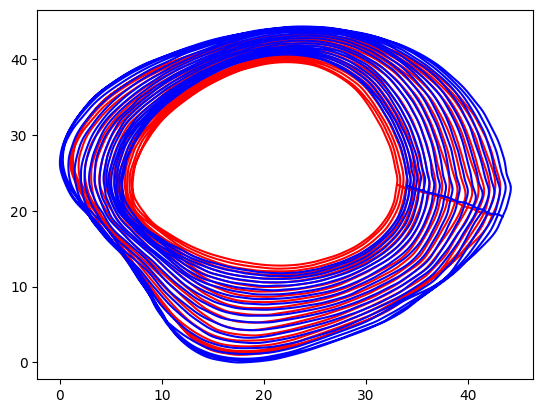

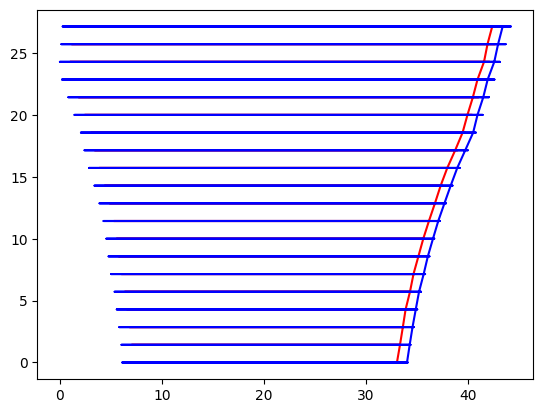

In [26]:
import pyvista as pv
import numpy as np
import shapely.geometry as sg
import shapely.ops as shpops
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.polygon import orient
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

def resample_polygon(polygon, num_points):
    """Resample the polygon to have a specific number of points using scipy."""
    x, y = polygon.exterior.xy
    tck, u = splprep([x, y], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck)
    return np.array(list(zip(x_new, y_new)))

def sort_points_cw(centroid, points):
    """Sort points in clockwise direction and rotate to start at the closest point to 0°."""
    angles = np.arctan2(points[:, 1] - centroid[1], points[:, 0] - centroid[0])
    angles = -angles
    sorted_indices = np.argsort(angles)
    sorted_points = points[sorted_indices]
    target_angle = np.deg2rad(10)
    start_index = np.argmin(np.abs(angles[sorted_indices] - target_angle))
    sorted_points = np.roll(sorted_points, -start_index, axis=0)
    sorted_points[-1] = sorted_points[0]
    return sorted_points

points_peri = pv.read('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/ssm_periosteum.vtk')
unique_z = np.unique(points_peri.points[:, 2])
unique_z = unique_z[::23]
print(len(unique_z))

modified_points = []
ext_points = []
# centroid = np.mean(points_peri.points, axis=0)[:2]
for z in unique_z:
    slice_points = points_peri.points[np.isclose(points_peri.points[:, 2], z, atol=0.01)][:, :2]
    num_points = 500
    
    offset = 1 / 0.061
    poly = sg.Polygon(slice_points)
    buffer = poly.buffer(-offset)
    
    if buffer.is_empty:
        continue
    
    if isinstance(buffer, sg.MultiPolygon):
        buffer = shpops.unary_union(buffer)
    
    buffer_union = shpops.unary_union(buffer)
    
    if not isinstance(buffer_union, sg.Polygon):
        continue
    
    int_points = np.array(buffer_union.convex_hull.exterior.coords)
    
    # Resample the buffered polygon to have the same number of points as the original slice
    resampled_int_points = resample_polygon(buffer_union.convex_hull, num_points)
    resampled_ext_points = resample_polygon(poly, num_points)
    
    # Sort points in CCW direction and rotate to start at the closest point to 0°
    centroid = np.mean(resampled_int_points, axis=0)
    resampled_int_points = sort_points_cw(centroid, resampled_int_points)
    resampled_ext_points = sort_points_cw(centroid, resampled_ext_points)
    
    int_points_3d = np.hstack((resampled_int_points, np.full((resampled_int_points.shape[0], 1), z)))
    ext_points_3d = np.hstack((resampled_ext_points, np.full((resampled_ext_points.shape[0], 1), z)))
    modified_points.append(int_points_3d)
    ext_points.append(ext_points_3d)

modified_points = np.vstack(modified_points)
original_points = np.vstack(ext_points)

modified_points = modified_points * 0.061
original_points = original_points * 0.061

# Shift all points in z-axis to positive values
modified_points[:, 2] = modified_points[:, 2] - np.min(modified_points[:, 2])
original_points[:, 2] = original_points[:, 2] - np.min(original_points[:, 2])
# shift all x-y points to positive values
offset_x = np.min([np.min(modified_points[:, 0]), np.min(original_points[:, 0])])
offset_y = np.min([np.min(modified_points[:, 1]), np.min(original_points[:, 1])])

modified_points[:, 0] = modified_points[:, 0] - offset_x
modified_points[:, 1] = modified_points[:, 1] - offset_y
original_points[:, 0] = original_points[:, 0] - offset_x
original_points[:, 1] = original_points[:, 1] - offset_y

# Plot the results slice by slice
# unique_z_mm = np.unique(modified_points[:, 2])
# plt.plot(figsize=(5,5))
# for z in unique_z_mm:
#     slice_points = modified_points[modified_points[:, 2] == z][:, :2]
#     plt.plot(slice_points[:, 0], slice_points[:, 1], 'r')
#     plt.scatter(slice_points[0, 0], slice_points[0, 1], c='g', label='start point')
#     plt.scatter(slice_points[-1, 0], slice_points[-1, 1], c='b', label='end point')
#     slice_points = original_points[original_points[:, 2] == z][:, :2]
#     plt.plot(slice_points[:, 0], slice_points[:, 1], 'b')
# print(np.shape(modified_points))
# print(np.shape(original_points))

modified_points = modified_points # .astype(np.float32)
original_points = original_points # .astype(np.float32)


# change modified points and original points z-values (linspace from 0 to 450*0.061)
# modified_points[:, 2] = np.linspace(0, z_max_mm, len(modified_points))
# original_points[:, 2] = np.linspace(0, z_max_mm, len(original_points))


z_max_mm = 445 * 0.061
unique_z = np.unique(modified_points[:, 2])
z_values = np.linspace(0, z_max_mm, len(unique_z))

for i, z in enumerate(unique_z):
    modified_points[modified_points[:, 2] == z, 2] = z_values[i]
    original_points[original_points[:, 2] == z, 2] = z_values[i]

plt.figure()
plt.plot(modified_points[:, 0], modified_points[:, 1], 'r')
plt.plot(original_points[:, 0], original_points[:, 1], 'b')
plt.show()

plt.figure()
plt.plot(modified_points[:, 0], modified_points[:, 2], 'r')
plt.plot(original_points[:, 0], original_points[:, 2], 'b')
plt.show()


np.save('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/00_ORIGAIM/SSM/ssm_endosteum_offset.npy', modified_points)
np.save('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/00_ORIGAIM/SSM/ssm_periosteum_original.npy', original_points)